In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
import matplotlib.patches as mpatches


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


In [2]:
'''
DIRECTORIES
'''

# plot output directory
output_dir = '/nesi/project/niwa00018/queenle/ml_emulator_experiment_application/plot_results/error_plots/'


In [3]:
'''
LOAD ERROR DATA AND METADATA
'''

error_df = pd.read_csv('error_results.csv').drop('Unnamed: 0',axis=1)

emulators = {'tasmax':error_df[error_df['var']=='tasmax']['emulator'].unique().tolist(),
             'pr':error_df[error_df['var']=='pr']['emulator'].unique().tolist()}

metrics = {'tasmax':error_df[error_df['var']=='tasmax']['metric'].unique().tolist(),
           'pr':error_df[error_df['var']=='pr']['metric'].unique().tolist()}

base_period = error_df['base period'].unique()[0].split('_')
future_period = error_df['future period'].unique()[0].split('_')

In [8]:
one_GCM_emulators = {'tasmax': ['tasmax_perfect_ACCESS-CM2_batch_16',
                      'tasmax_perfect_EC-Earth3_batch_16',
                      'tasmax_perfect_NorESM2-MM_batch_16'],
                     'pr': ['pr_perfect_ACCESS-CM2_batch_16',
                      'pr_perfect_EC-Earth3_batch_16',
                      'pr_perfect_NorESM2-MM_batch_16']}

two_GCM_emulators = {'tasmax': ['tasmax_perfect_ACCESS-CM2_EC-Earth3_batch_8',
                      'tasmax_perfect_ACCESS-CM2_NorESM2-MM_batch_8',
                      'tasmax_perfect_EC-Earth3_NorESM2-MM_batch_8'],
                     'pr': ['pr_perfect_ACCESS-CM2_EC-Earth3_batch_8',
                      'pr_perfect_ACCESS-CM2_NorESM2-MM_batch_8',
                      'pr_perfect_EC-Earth3_NorESM2-MM_batch_8']}

five_GCM_emulators = {'tasmax':['NIWA-REMS_tasmax_v280125'],'pr':['NIWA-REMS_pr_v280125']}

In [24]:
emulators

{'tasmax': ['tasmax_perfect_ACCESS-CM2_batch_16',
  'tasmax_perfect_EC-Earth3_batch_16',
  'tasmax_perfect_NorESM2-MM_batch_16',
  'tasmax_perfect_ACCESS-CM2_EC-Earth3_batch_8',
  'tasmax_perfect_ACCESS-CM2_NorESM2-MM_batch_8',
  'tasmax_perfect_EC-Earth3_NorESM2-MM_batch_8',
  'NIWA-REMS_tasmax_v280125',
  'tasmax_perfect_ACCESS-CM2_moved_shuffle'],
 'pr': ['pr_perfect_ACCESS-CM2_batch_16',
  'pr_perfect_EC-Earth3_batch_16',
  'pr_perfect_NorESM2-MM_batch_16',
  'pr_perfect_ACCESS-CM2_EC-Earth3_batch_8',
  'pr_perfect_ACCESS-CM2_NorESM2-MM_batch_8',
  'pr_perfect_EC-Earth3_NorESM2-MM_batch_8',
  'NIWA-REMS_pr_v280125',
  'pr_perfect_ACCESS-CM2_moved_shuffle']}

In [26]:
'''
PLOTTING VARIABLES
'''

markers = ['*','o','x']
ml_colors = ['red','yellow','orange','blue','green','purple']

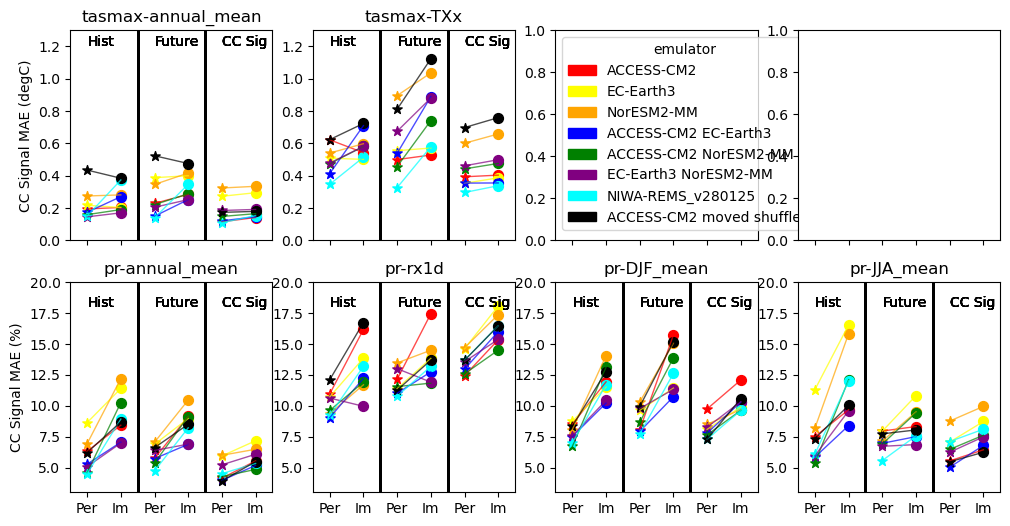

In [30]:
fig,axs = plt.subplots(2,4,figsize=(12,6),sharex=True)

markers = ['*','o','x']
ml_colors = ['red','yellow','orange','blue','green','purple','cyan','black']

plot_dict = {'temp':['tasmax-annual_mean','tasmax-TXx'],
             'precip':['pr-annual_mean','pr-rx1d','pr-DJF_mean','pr-JJA_mean']}


for i,variable in enumerate(['temp','precip']):
    
    for j,plot in enumerate(plot_dict[variable]):
        
        var = plot.split('-')[0]
        metric = plot.split('-')[1]
        
        for x,scen in enumerate(['Hist','Future','CC Sig']):
            
            if scen == 'CC Sig':
                subset_df = error_df[(error_df['var']==var) & (error_df['metric']==metric) & (error_df['error period']=='CC signal')]
                
            elif scen == 'Hist':
                subset_df = error_df[(error_df['var']==var) & (error_df['metric']==metric) & (error_df['error period']==f'{base_period[0]}_{base_period[1]}')]        
            
            elif scen == 'Future':
                subset_df = error_df[(error_df['var']==var) & (error_df['metric']==metric) & (error_df['error period']==f'{future_period[0]}_{future_period[1]}')]        


            #NorESM2_mm_points = []
            for ml_color,emulator in enumerate(emulators[var]):

                gcm_mean_points = []
                for f,framework in enumerate(['perfect','imperfect']):

                    config_df = subset_df[(subset_df['emulator'] == emulator) & (subset_df['framework'] == framework)]

                    land_error_gcm_mean = config_df['land'].mean()

                    axs[i][j].scatter(2*x+f,land_error_gcm_mean,marker = markers[f],s=50,color=ml_colors[ml_color],label='')#framework if (x == 0 and ml_color==0) else '')
                    #axs[i][j].scatter(k,config_df[config_df['GCM']=='NorESM2-MM']['land'],color='limegreen',s=14)

                    gcm_mean_points.append(land_error_gcm_mean)
                    #NorESM2_mm_points.append(config_df[config_df['GCM']=='NorESM2-MM']['land'])


                axs[i][j].plot([2*x+i for i in range(len(gcm_mean_points))],gcm_mean_points,color=ml_colors[ml_color],alpha=0.7,linewidth=1)
                #axs[i][j].plot([i for i in range(len(NorESM2_mm_points))],NorESM2_mm_points,color='limegreen',alpha=0.7,linewidth=0.8)


                axs[i][j].set_title(plot)
                axs[i][j].set_xlim(-0.5,5.5)

                if i == 0:
                    axs[i][j].set_ylim(0,1.3)
                    axs[i][j].text(2*x,1.2,scen)
                    #if j == 0:
                    #    axs[i][j].legend(loc='center left')

                if i == 1:
                    axs[i][j].set_ylim(3,20)
                    axs[i][j].text(2*x,18,scen)
                    axs[i][j].set_xticks([0,1,2,3,4,5],['Per','Im','Per','Im','Per','Im'])
                    
                axs[i][j].axvline(1.5,color='black',linewidth=1)
                axs[i][j].axvline(3.5,color='black',linewidth=1)
                
                
            
axs[0][0].set_ylabel('CC Signal MAE (degC)')
axs[1][0].set_ylabel('CC Signal MAE (%)')   
    
color_patches = []
for ml_color,emulator in enumerate(emulators['tasmax']):
    short_name = " ".join(emulator.split('_')[2:-2])
    if emulator == 'NIWA-REMS_tasmax_v280125':
        short_name = 'NIWA-REMS_v280125'
    elif emulator == 'tasmax_perfect_ACCESS-CM2_moved_shuffle':
        short_name = 'ACCESS-CM2 moved shuffle'
    color_patches.append(mpatches.Patch(color=ml_colors[ml_color], label=short_name))

axs[0][2].legend(handles=color_patches,loc='upper left',title='emulator')

#plt.savefig('./error_plots/CC_error_summary_land_gcm_mean.png')


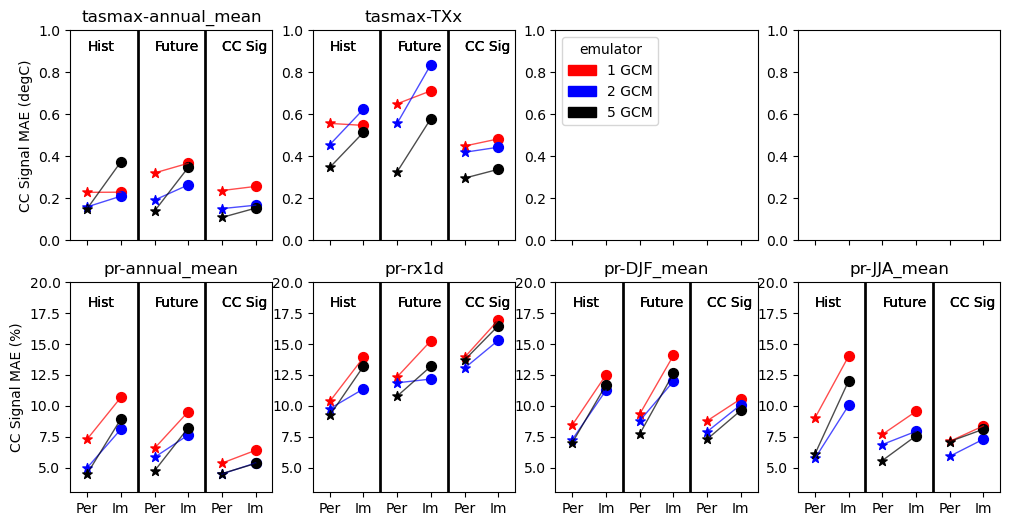

In [28]:
'''
1GCM vs 2GCM
'''

fig,axs = plt.subplots(2,4,figsize=(12,6),sharex=True)

markers = ['*','o','x']
ml_colors = ['red','blue','black']

plot_dict = {'temp':['tasmax-annual_mean','tasmax-TXx'],
             'precip':['pr-annual_mean','pr-rx1d','pr-DJF_mean','pr-JJA_mean']}

for i,variable in enumerate(['temp','precip']):
    
    for j,plot in enumerate(plot_dict[variable]):
        
        var = plot.split('-')[0]
        metric = plot.split('-')[1]
        
        for x,scen in enumerate(['Hist','Future','CC Sig']):
            
            if scen == 'CC Sig':
                subset_df = error_df[(error_df['var']==var) & (error_df['metric']==metric) & (error_df['error period']=='CC signal')]
                
            elif scen == 'Hist':
                subset_df = error_df[(error_df['var']==var) & (error_df['metric']==metric) & (error_df['error period']==f'{base_period[0]}_{base_period[1]}')]        
            
            elif scen == 'Future':
                subset_df = error_df[(error_df['var']==var) & (error_df['metric']==metric) & (error_df['error period']==f'{future_period[0]}_{future_period[1]}')]        


            #NorESM2_mm_points = []
            for ml_color,emulator_list in enumerate([one_GCM_emulators[var],two_GCM_emulators[var],five_GCM_emulators[var]]):

                gcm_mean_points = []
                for f,framework in enumerate(['perfect','imperfect']):

                    config_df = subset_df[subset_df['emulator'].isin(emulator_list)]
                    config_df = config_df[config_df['framework']==framework]

                    land_error_gcm_mean = config_df['land'].mean()

                    axs[i][j].scatter(2*x+f,land_error_gcm_mean,marker = markers[f],s=50,color=ml_colors[ml_color],label='')#framework if (x == 0 and ml_color==0) else '')
                    #axs[i][j].scatter(k,config_df[config_df['GCM']=='NorESM2-MM']['land'],color='limegreen',s=14)

                    gcm_mean_points.append(land_error_gcm_mean)
                    #NorESM2_mm_points.append(config_df[config_df['GCM']=='NorESM2-MM']['land'])


                axs[i][j].plot([2*x+i for i in range(len(gcm_mean_points))],gcm_mean_points,color=ml_colors[ml_color],alpha=0.7,linewidth=1)
                #axs[i][j].plot([i for i in range(len(NorESM2_mm_points))],NorESM2_mm_points,color='limegreen',alpha=0.7,linewidth=0.8)


                axs[i][j].set_title(plot)
                axs[i][j].set_xlim(-0.5,5.5)

                if i == 0:
                    axs[i][j].set_ylim(0,1)
                    axs[i][j].text(2*x,0.9,scen)
                    #if j == 0:
                    #    axs[i][j].legend(loc='center left')

                if i == 1:
                    axs[i][j].set_ylim(3,20)
                    axs[i][j].text(2*x,18,scen)
                    axs[i][j].set_xticks([0,1,2,3,4,5],['Per','Im','Per','Im','Per','Im'])
                    
                axs[i][j].axvline(1.5,color='black',linewidth=1)
                axs[i][j].axvline(3.5,color='black',linewidth=1)
                
                
            
axs[0][0].set_ylabel('CC Signal MAE (degC)')
axs[1][0].set_ylabel('CC Signal MAE (%)')   
    
color_patches = []
for ml_color,emulator in enumerate(['1 GCM','2 GCM','5 GCM']):
    #short_name = " ".join(emulator.split('_')[2:-2])
    color_patches.append(mpatches.Patch(color=ml_colors[ml_color], label=emulator))

axs[0][2].legend(handles=color_patches,loc='upper left',title='emulator')

#plt.savefig('./error_plots/CC_error_summary_land_gcm_mean.png')


In [4]:
emulators

{'tasmax': ['tasmax_perfect_ACCESS-CM2_batch_16',
  'tasmax_perfect_EC-Earth3_batch_16',
  'tasmax_perfect_NorESM2-MM_batch_16',
  'tasmax_perfect_ACCESS-CM2_EC-Earth3_batch_8',
  'tasmax_perfect_ACCESS-CM2_NorESM2-MM_batch_8',
  'tasmax_perfect_EC-Earth3_NorESM2-MM_batch_8',
  'NIWA-REMS_tasmax_v280125',
  'tasmax_perfect_ACCESS-CM2_moved_shuffle'],
 'pr': ['pr_perfect_ACCESS-CM2_batch_16',
  'pr_perfect_EC-Earth3_batch_16',
  'pr_perfect_NorESM2-MM_batch_16',
  'pr_perfect_ACCESS-CM2_EC-Earth3_batch_8',
  'pr_perfect_ACCESS-CM2_NorESM2-MM_batch_8',
  'pr_perfect_EC-Earth3_NorESM2-MM_batch_8',
  'NIWA-REMS_pr_v280125',
  'pr_perfect_ACCESS-CM2_moved_shuffle']}

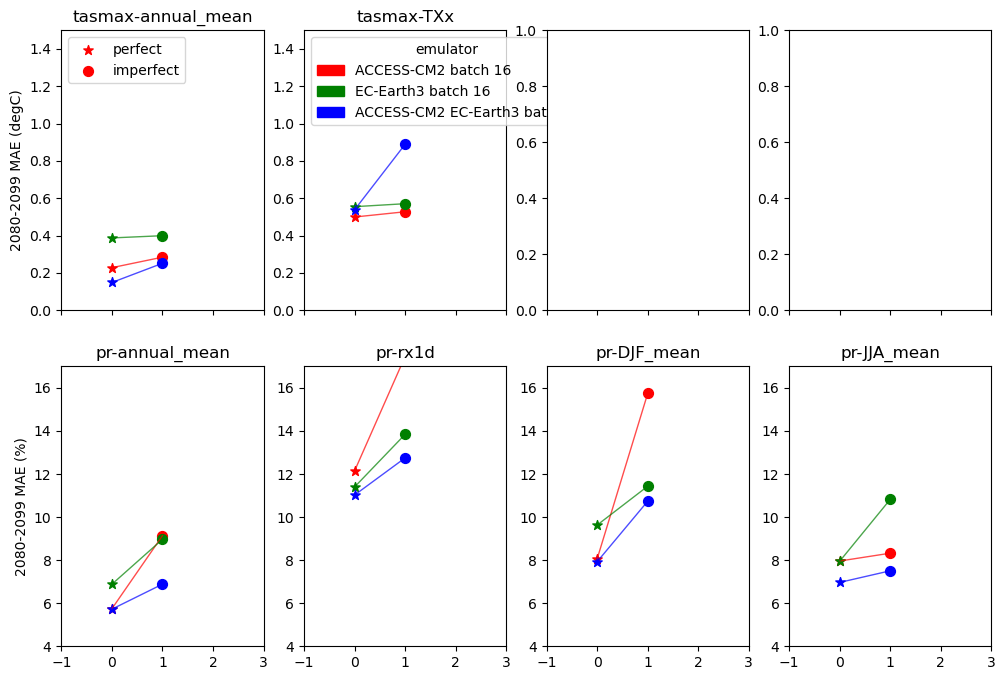

In [13]:
fig,axs = plt.subplots(2,4,figsize=(12,8),sharex=True)

plot_dict = {'temp':['tasmax-annual_mean','tasmax-TXx'],
             'precip':['pr-annual_mean','pr-rx1d','pr-DJF_mean','pr-JJA_mean']}

period = ['2080','2099']
for i,variable in enumerate(['temp','precip']):
    
    for j,plot in enumerate(plot_dict[variable]):
        
        var = plot.split('-')[0]
        metric = plot.split('-')[1]
        
        subset_df = period_errors_df[(period_errors_df['var']==var) & (period_errors_df['metric']==metric) & (period_errors_df['period']==f'{period[0]}_{period[1]}')]        
        
        #NorESM2_mm_points = []
        for ml_color,ml_model_type in enumerate(ml_model_types):
            emulator = f'{var}_{ml_model_type}'
            
            gcm_mean_points = []
            for f,framework in enumerate(['perfect','imperfect']):

                config_df = subset_df[(subset_df['emulator'] == emulator) & (subset_df['framework'] == framework)]

                land_error_gcm_mean = config_df['land'].mean()

                axs[i][j].scatter(f,land_error_gcm_mean,marker = markers[f],s=50,color=ml_colors[ml_color],label=framework if ml_color == 0 else '')
                #axs[i][j].scatter(k,config_df[config_df['GCM']=='NorESM2-MM']['land'],color='limegreen',s=14)

                gcm_mean_points.append(land_error_gcm_mean)
                #NorESM2_mm_points.append(config_df[config_df['GCM']=='NorESM2-MM']['land'])


            axs[i][j].plot([i for i in range(len(gcm_mean_points))],gcm_mean_points,color=ml_colors[ml_color],alpha=0.7,linewidth=1)
            #axs[i][j].plot([i for i in range(len(NorESM2_mm_points))],NorESM2_mm_points,color='limegreen',alpha=0.7,linewidth=0.8)

            axs[i][j].set_title(plot)
            axs[i][j].set_xlim(-1,3)

            if i == 0:
                axs[i][j].set_ylim(0,1.5)
                if j == 0:
                    axs[i][j].legend(loc='upper left')

            if i == 1:
                axs[i][j].set_ylim(4,17)
            
axs[0][0].set_ylabel(f'{period[0]}-{period[1]} MAE (degC)')
axs[1][0].set_ylabel(f'{period[0]}-{period[1]} MAE (%)')   

color_patches = []
for ml_color,ml_model_type in enumerate(ml_model_types):
    short_name = " ".join(ml_model_type.split('_')[1:])
    color_patches.append(mpatches.Patch(color=ml_colors[ml_color], label=short_name))

axs[0][1].legend(handles=color_patches,loc='upper left',title='emulator')

#plt.savefig('./error_plots/CC_error_summary_land_gcm_mean.png')
